In [21]:
import numpy as np
import pandas as pd 
from torchsummary import summary    
import os
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from tqdm import tqdm
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset
import random
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import PIL.Image as Image
import os
from sklearn.metrics import jaccard_score, f1_score
# import wandb
import torchvision
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from scipy.spatial.distance import directed_hausdorff
import re
import cv2

In [22]:
train_dir = "/home/dawlat.akaila/Documents/DL_LABS/PROJECT/deeplab/image"
train_mask_dir = "/home/dawlat.akaila/Documents/DL_LABS/PROJECT/deeplab/mask"

In [23]:
def get_patient_ids(image_dir):
    filenames = os.listdir(image_dir)
    patient_ids = set()
    
    for filename in filenames:
        if re.match(r'^\d+[A-Z]?_\d+\.png$', filename):
            # Format 1
            patient_id = re.match(r'^(\d+[A-Z]?)_', filename).group(1)
        elif re.match(r'^Image_\d+\.png$', filename):
            # Format 2
            number = int(re.match(r'^Image_(\d+)\.png$', filename).group(1))
            if 168 <= number <= 194:
                patient_id = 'patient_1'
            elif 424 <= number <= 517:
                patient_id = 'patient_2'
            elif 658 <= number <= 710:
                patient_id = 'patient_3'
            elif 3542 <= number <= 3969:
                patient_id = 'patient_4'
            else:
                continue  # Skip if the number doesn't fall in the specified ranges
        elif re.match(r'^\d+-\d+-\d+-(\d+) - \d+\.png$', filename):
            # Format 3
            patient_id = re.match(r'^\d+-\d+-\d+-(\d+) - \d+\.png$', filename).group(1)
        else:
            continue  # Skip filenames that don't match any known format
        
        patient_ids.add(patient_id)
    
    return list(patient_ids)

# Example usage
patient_ids = get_patient_ids(train_dir)

random.shuffle(patient_ids)
num_val_patients = int(0.20 * len(patient_ids))

val_patient_ids = patient_ids[:num_val_patients]
train_patient_ids = patient_ids[num_val_patients:]

print("Validation Patient IDs:", val_patient_ids)
print("Training Patient IDs:", train_patient_ids)


Validation Patient IDs: ['44221290379A']
Training Patient IDs: ['patient_1', '1755', '1842', '1500', '44221602689A', '44220980309A', 'patient_4']


In [26]:
class UltrasoundDataset(Dataset):
    def __init__(self, image_dir, mask_dir, patient_ids=None, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.patient_ids = patient_ids
        self.transform = transform

        # Filtering images based on patient IDs if provided
        if patient_ids is not None:
            self.images = [img for img in os.listdir(image_dir) if self._extract_patient_id(img) in patient_ids]
        else:
            self.images = [img for img in os.listdir(image_dir) if self._is_valid_image(img)]

    def __len__(self):
        return len(self.images)

    def _is_valid_image(self, filename):
        return filename.endswith(('.tif', '.png'))

    def _extract_patient_id(self, filename):
        if re.match(r'^\d+[A-Z]?_\d+\.png$', filename):
            # Format 1
            return re.match(r'^(\d+[A-Z]?)_', filename).group(1)
        elif re.match(r'^Image_\d+\.png$', filename):
            # Format 2
            number = int(re.match(r'^Image_(\d+)\.png$', filename).group(1))
            if 168 <= number <= 194:
                return 'patient_1'
            elif 424 <= number <= 517:
                return 'patient_2'
            elif 658 <= number <= 710:
                return 'patient_3'
            elif 3542 <= number <= 3969:
                return 'patient_4'
        elif re.match(r'^\d+-\d+-\d+-(\d+) - \d+\.png$', filename):
            # Format 3
            return re.match(r'^\d+-\d+-\d+-(\d+) - \d+\.png$', filename).group(1)
        return None

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name.rsplit('.', 1)[0] + '.' + img_name.rsplit('.', 1)[1]
        mask_path = os.path.join(self.mask_dir, mask_name)
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0
        mask[mask>0]=1.0

        # Process mask
        mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        _, binary_image = cv2.threshold(mask_image, 1, 255, cv2.THRESH_BINARY)
        kernel = np.ones((5, 5), np.uint16)  # Adjust kernel size if necessary
        closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
        # Smoothen the edges
        mask = cv2.GaussianBlur(closed_image, (0, 0), sigmaX=3, sigmaY=3, borderType=cv2.BORDER_DEFAULT)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return img_name, image, mask

In [27]:
resize = 448

train_transform = A.Compose(
    [
        A.LongestMaxSize(max_size=resize),
        A.PadIfNeeded(
            min_height=resize, 
            min_width=resize, 
            border_mode=cv2.BORDER_CONSTANT,
            value=[0, 0, 0]  # Padding with black color for RGB images
        ),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.LongestMaxSize(max_size=resize),
        A.PadIfNeeded(
            min_height=resize, 
            min_width=resize, 
            border_mode=cv2.BORDER_CONSTANT,
            value=[0, 0, 0]  # Padding with black color for RGB images
        ),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)



train_dataset = UltrasoundDataset(train_dir, train_mask_dir, transform=train_transform)
val_dataset = UltrasoundDataset(train_dir, train_mask_dir, val_patient_ids, test_transform)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


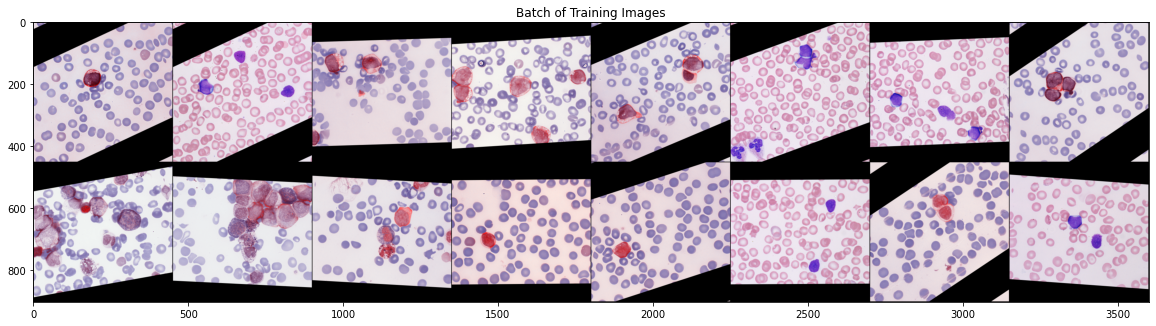

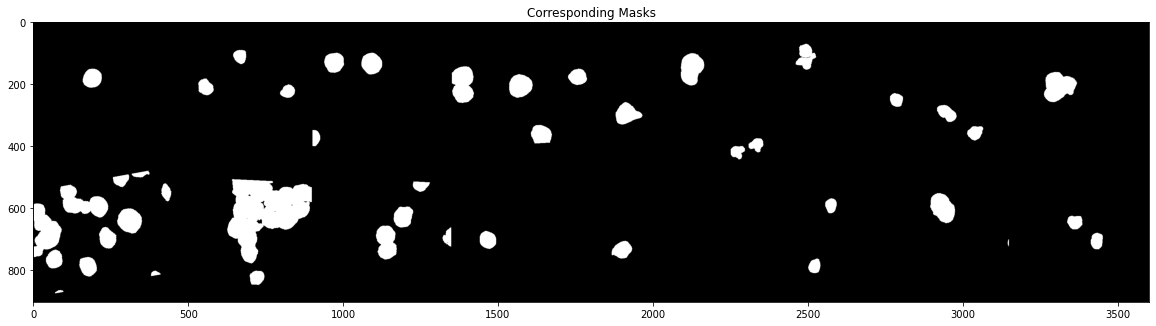

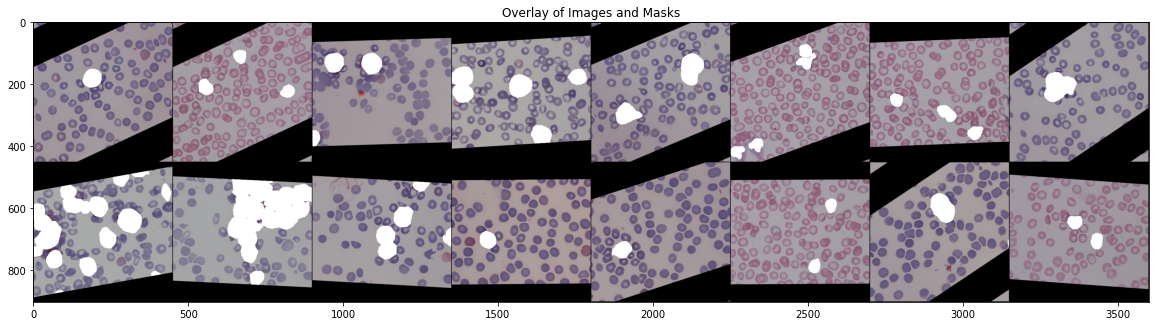

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(inp, title=None, figsize=(20, 10)):
    """Imshow for Tensor."""
    inp = inp.detach().cpu().numpy().transpose((1, 2, 0))
    if inp.shape[2] == 1:  # Check for single-channel image (mask)
        inp = np.repeat(inp, 3, axis=2)  # Repeat the channel to make it 3-channel
    mean = np.array([0.0, 0.0, 0.0])
    std = np.array([1.0, 1.0, 1.0])
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause to update the figure

# Assume train_loader is already defined and loaded with UltrasoundDataset
_, images, masks = next(iter(train_loader))

# Visualize images
out_images = torchvision.utils.make_grid(images)
imshow(out_images, title="Batch of Training Images")

# Visualize masks in the same grid format as the images
masks = masks.unsqueeze(1)  # Add a channel dimension to the masks
masks = masks.repeat(1, 3, 1, 1)  # Convert single-channel masks to 3-channel
out_masks = torchvision.utils.make_grid(masks)
imshow(out_masks, title="Corresponding Masks")

# Overlaying masks on images
overlay = images.clone()
alpha = 0.7  # Transparency for the original image
beta = 0.3  # Transparency for the mask
for i in range(overlay.shape[0]):  # Correct iteration over batch size
    overlay[i] = images[i] * alpha + masks[i] * beta  # Apply blending

# Make a grid from the overlay batch and visualize
overlay_grid = torchvision.utils.make_grid(overlay)
imshow(overlay_grid, title="Overlay of Images and Masks")


In [29]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [30]:
model = torch.hub.load('pytorch/vision:v0.8.0', 'deeplabv3_resnet50', pretrained=True)

# Modify the last convolutional layer
model.classifier[4] = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=(1,1))

# If there's an auxiliary classifier, modify it similarly
if model.aux_classifier is not None:
    model.aux_classifier[4] = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=(1,1))

model.to(device)

Using cache found in /home/dawlat.akaila/.cache/torch/hub/pytorch_vision_v0.8.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [31]:
# Dice score calculation
def dice_score(preds, labels, smooth=1e-6):
    preds = (preds > 0.5).float()  # Binarize predictions
    labels = (labels > 0.5).float()  # Binarize labels
    
    intersection = (preds * labels).sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (preds.sum(dim=(2, 3)) + labels.sum(dim=(2, 3)) + smooth)
    return dice.mean().item()

In [32]:
# Setting Hyperparams
lr = 1e-4
epochs = 20
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
scaler = torch.cuda.amp.GradScaler()

In [33]:
best_test_accuracy = 0.0
best_test_dice = 0.0

# Training loop
for epoch in range(epochs):  # loop over the dataset multiple times
    torch.cuda.empty_cache()

    # Training phase
    model.train()
    train_running_loss = 0.0
    train_total = 0
    train_correct = 0
    train_dice_total = 0
    train_batches = 0
    train_loader_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1} [TRAIN]", leave=False)

    for _, inputs, labels in train_loader_pbar:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # Ensure labels are in float and add channel dimension if needed

        with torch.cuda.amp.autocast():
            outputs = model(inputs)['out']
            loss = criterion(outputs, labels)
            predicted_masks = torch.sigmoid(outputs)  # Apply sigmoid to get predicted mask values between 0 and 1

        # Backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_running_loss += loss.item()

        binary_predicted_masks = (predicted_masks > 0.5).float()  # Threshold predictions to binary

        train_total += labels.numel()
        train_correct += (binary_predicted_masks == labels).sum().item()
        train_dice_total += dice_score(binary_predicted_masks, labels)
        train_batches += 1

    train_loss = train_running_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total  # Convert to percentage
    train_dice_score_avg = train_dice_total / train_batches * 100  # Convert to percentage

    print(f'Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training Dice: {train_dice_score_avg:.2f}%')

    # Validation phase
    model.eval()
    test_running_loss = 0.0
    test_total = 0
    test_correct = 0
    test_dice_total = 0.0
    test_batches = 0
    test_loader_pbar = tqdm(val_loader, desc=f"Epoch {epoch + 1} [TEST]", leave=False)
    with torch.no_grad():
        for _, inputs, labels in test_loader_pbar:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)  # Ensure labels are in float and add channel dimension if needed

            outputs = model(inputs)['out']
            loss = criterion(outputs, labels)
            predicted_masks = torch.sigmoid(outputs)  # Apply sigmoid to get predicted mask values between 0 and 1

            test_running_loss += loss.item()

            binary_predicted_masks = (predicted_masks > 0.5).float()  # Threshold predictions to binary

            test_total += labels.numel()
            test_correct += (binary_predicted_masks == labels).sum().item()
            test_dice_total += dice_score(binary_predicted_masks, labels)
            test_batches += 1

    test_loss = test_running_loss / len(val_loader)
    test_accuracy = 100 * test_correct / test_total  # Convert to percentage
    test_dice_score_avg = test_dice_total / test_batches * 100  # Convert to percentage

    print(f'Epoch {epoch + 1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Dice: {test_dice_score_avg:.2f}%')

    # Checkpointing
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy

    if test_dice_score_avg > best_test_dice:
        best_test_dice = test_dice_score_avg
        torch.save(model.state_dict(), "deeplabv3_leukemia_AR.pth")
        print(f"Checkpoint saved at epoch {epoch + 1} with Test Dice Score: {test_dice_score_avg:.2f}% and Test Accuracy: {test_accuracy:.2f}%")

    print("-" * 100)

print(f'Best Test Accuracy: {best_test_accuracy:.2f}%, Best Test Dice Score: {best_test_dice:.2f}%')

Epoch 1, Training Loss: -21.2969, Training Accuracy: 75.80%, Training Dice: 31.89%


Epoch 1, Test Loss: -317.3622, Test Accuracy: 74.41%, Test Dice: 67.21%
Checkpoint saved at epoch 1 with Test Dice Score: 67.21% and Test Accuracy: 74.41%
----------------------------------------------------------------------------------------------------


Epoch 2, Training Loss: -86.2453, Training Accuracy: 87.09%, Training Dice: 62.62%


Epoch 2, Test Loss: -300.0947, Test Accuracy: 79.99%, Test Dice: 78.10%
Checkpoint saved at epoch 2 with Test Dice Score: 78.10% and Test Accuracy: 79.99%
----------------------------------------------------------------------------------------------------


Epoch 3, Training Loss: -114.4054, Training Accuracy: 88.91%, Training Dice: 68.37%


Epoch 3, Test Loss: -328.2411, Test Accuracy: 77.22%, Test Dice: 72.93%
----------------------------------------------------------------------------------------------------


Epoch 4, Training Loss: -128.2521, Training Accuracy: 88.87%, Training Dice: 69.58%


Epoch 4, Test Loss: -333.5004, Test Accuracy: 77.24%, Test Dice: 72.98%
----------------------------------------------------------------------------------------------------


Epoch 5, Training Loss: -140.0031, Training Accuracy: 88.95%, Training Dice: 69.78%


Epoch 5, Test Loss: -311.8633, Test Accuracy: 76.13%, Test Dice: 71.63%
----------------------------------------------------------------------------------------------------


Epoch 6, Training Loss: -148.6083, Training Accuracy: 88.42%, Training Dice: 67.78%


Epoch 6, Test Loss: -397.9555, Test Accuracy: 74.93%, Test Dice: 69.00%
----------------------------------------------------------------------------------------------------


Epoch 7, Training Loss: -157.9578, Training Accuracy: 88.60%, Training Dice: 68.15%


Epoch 7, Test Loss: -465.3731, Test Accuracy: 66.75%, Test Dice: 56.93%
----------------------------------------------------------------------------------------------------


Epoch 8, Training Loss: -167.8445, Training Accuracy: 87.99%, Training Dice: 67.11%


Epoch 8, Test Loss: -400.9887, Test Accuracy: 76.85%, Test Dice: 72.32%
----------------------------------------------------------------------------------------------------


Epoch 9, Training Loss: -176.9898, Training Accuracy: 87.97%, Training Dice: 66.66%


Epoch 9, Test Loss: -473.9927, Test Accuracy: 75.70%, Test Dice: 70.49%
----------------------------------------------------------------------------------------------------


Epoch 10, Training Loss: -186.6113, Training Accuracy: 88.29%, Training Dice: 66.77%


Epoch 10, Test Loss: -464.2925, Test Accuracy: 75.24%, Test Dice: 69.88%
----------------------------------------------------------------------------------------------------


Epoch 11, Training Loss: -195.3624, Training Accuracy: 88.40%, Training Dice: 67.10%


Epoch 11, Test Loss: -497.2199, Test Accuracy: 76.67%, Test Dice: 71.90%
----------------------------------------------------------------------------------------------------


Epoch 12, Training Loss: -206.5674, Training Accuracy: 88.61%, Training Dice: 67.72%


Epoch 12, Test Loss: -513.0701, Test Accuracy: 77.47%, Test Dice: 73.59%
----------------------------------------------------------------------------------------------------


Epoch 13, Training Loss: -215.3454, Training Accuracy: 88.57%, Training Dice: 67.30%


Epoch 13, Test Loss: -541.3653, Test Accuracy: 77.09%, Test Dice: 73.04%
----------------------------------------------------------------------------------------------------


Epoch 14, Training Loss: -225.3986, Training Accuracy: 88.57%, Training Dice: 66.52%


Epoch 14, Test Loss: -549.2404, Test Accuracy: 75.65%, Test Dice: 70.14%
----------------------------------------------------------------------------------------------------


Epoch 15, Training Loss: -235.6356, Training Accuracy: 88.44%, Training Dice: 65.84%


Epoch 15, Test Loss: -577.2189, Test Accuracy: 77.66%, Test Dice: 73.99%
----------------------------------------------------------------------------------------------------


Epoch 16, Training Loss: -244.7403, Training Accuracy: 88.46%, Training Dice: 66.05%


Epoch 16, Test Loss: -595.8549, Test Accuracy: 76.37%, Test Dice: 71.38%
----------------------------------------------------------------------------------------------------


Epoch 17, Training Loss: -252.5070, Training Accuracy: 88.25%, Training Dice: 64.10%


Epoch 17, Test Loss: -643.5047, Test Accuracy: 73.48%, Test Dice: 66.47%
----------------------------------------------------------------------------------------------------


Epoch 18, Training Loss: -264.9806, Training Accuracy: 88.37%, Training Dice: 64.63%


Epoch 18, Test Loss: -676.1601, Test Accuracy: 75.11%, Test Dice: 68.91%
----------------------------------------------------------------------------------------------------


Epoch 19, Training Loss: -275.3366, Training Accuracy: 88.34%, Training Dice: 64.87%


Epoch 19, Test Loss: -630.5023, Test Accuracy: 75.40%, Test Dice: 69.72%
----------------------------------------------------------------------------------------------------


Epoch 20, Training Loss: -284.1913, Training Accuracy: 88.18%, Training Dice: 63.67%


Epoch 20, Test Loss: -669.5560, Test Accuracy: 75.47%, Test Dice: 69.62%
----------------------------------------------------------------------------------------------------
Best Test Accuracy: 79.99%, Best Test Dice Score: 78.10%


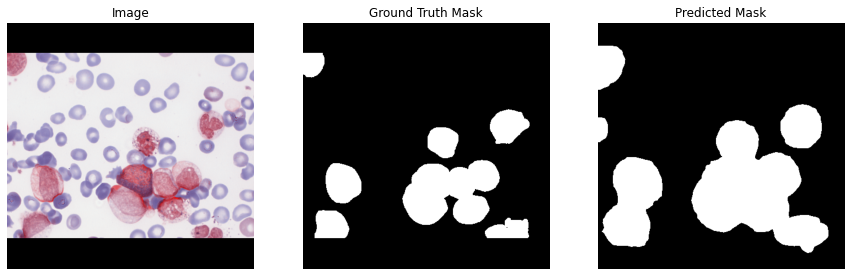

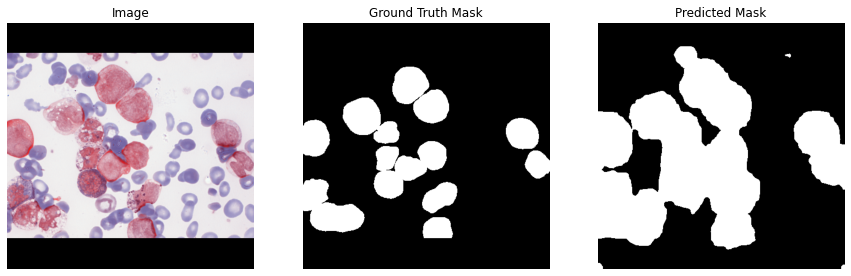

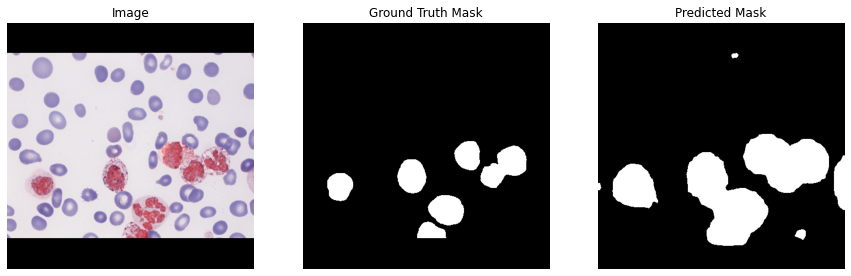

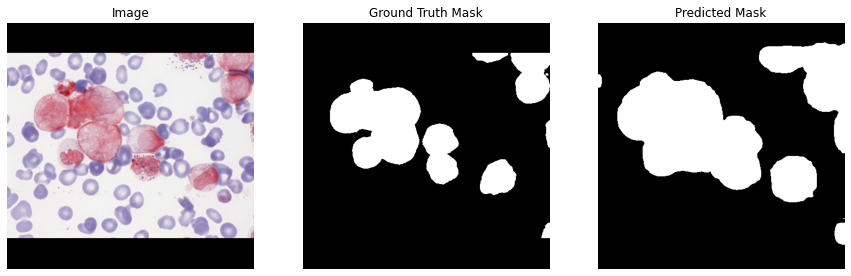

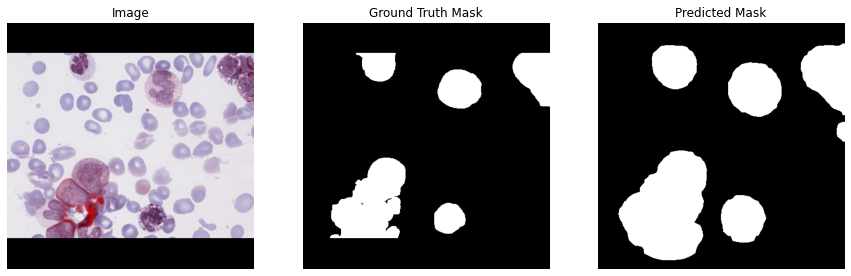

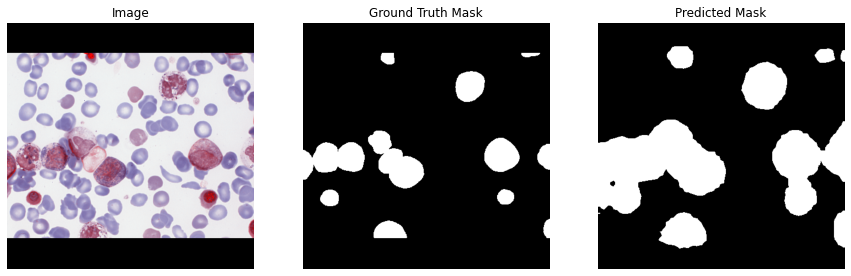

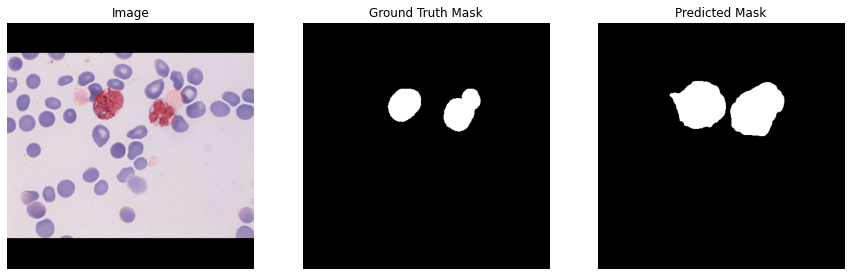

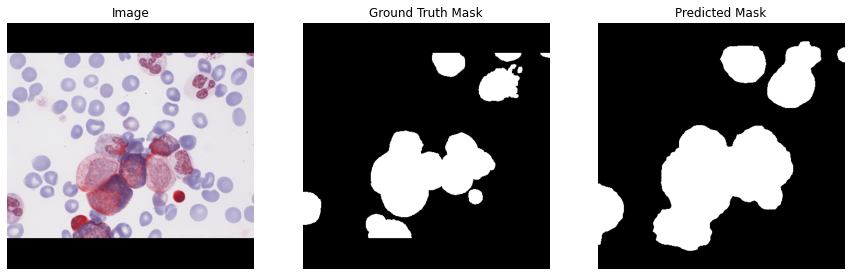

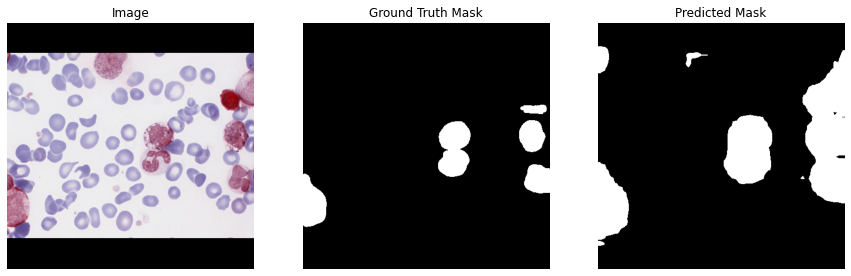

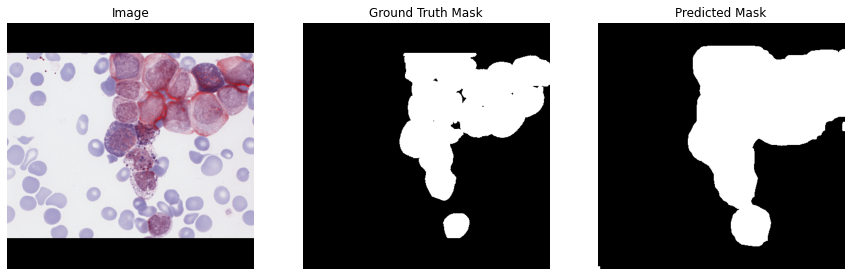

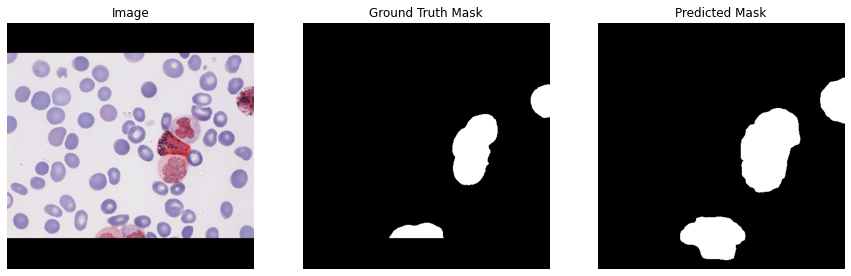

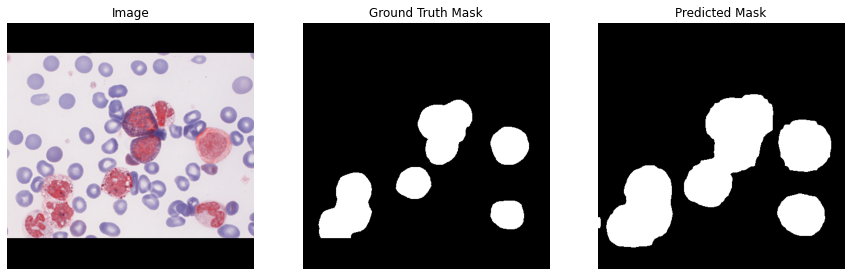

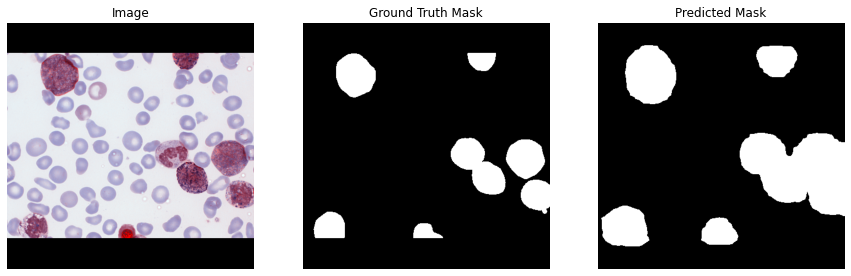

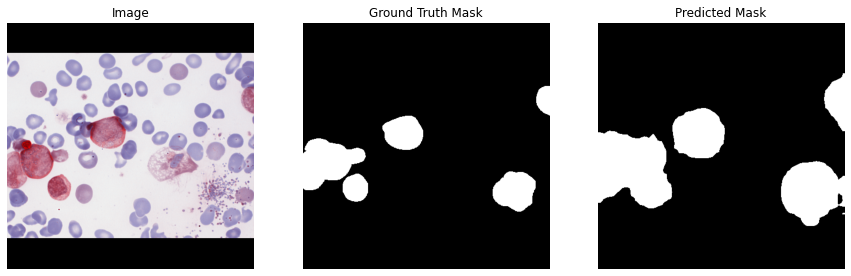

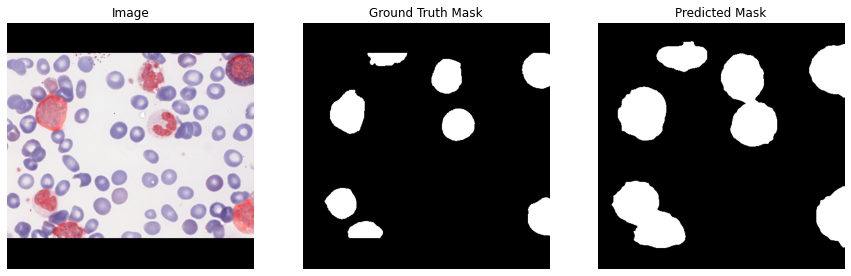

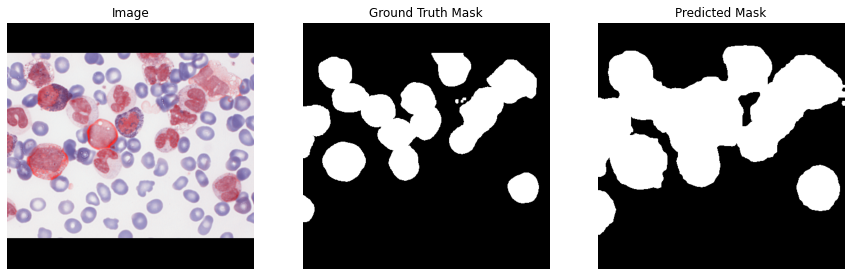

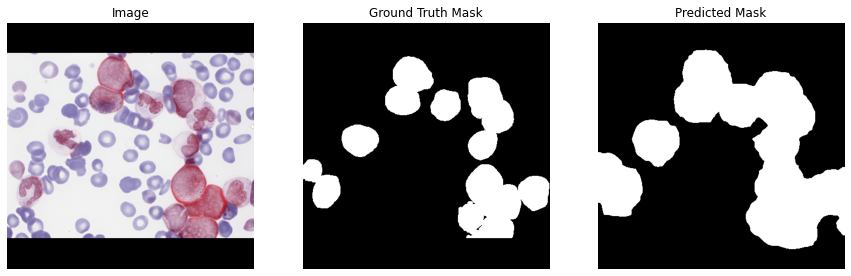

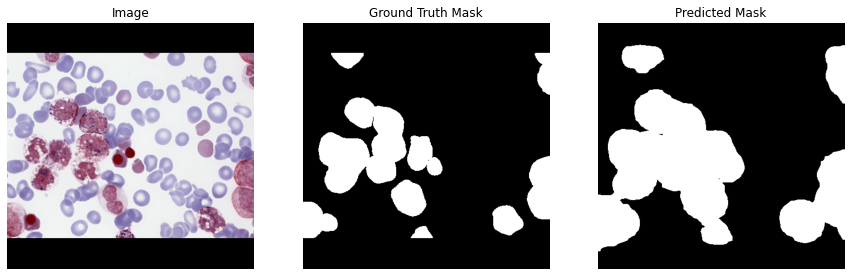

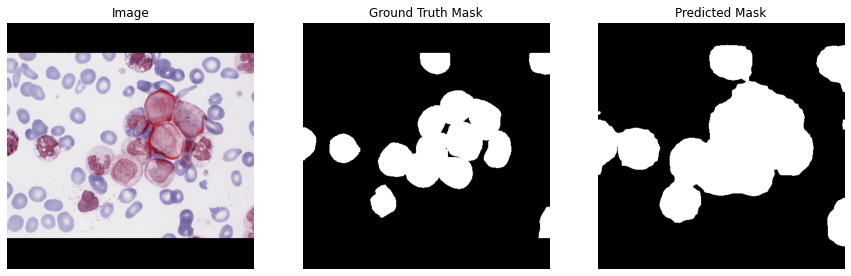

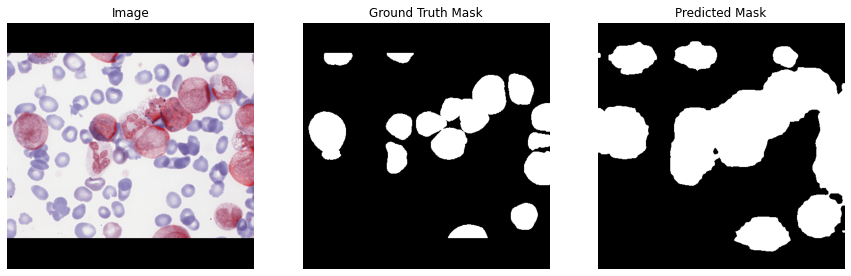

In [36]:
# Define a function to plot predictions vs ground truth
def plot_predictions(model, val_loader, device, num_samples=5):
    model.eval()
    with torch.no_grad():
        for i, (_, inputs, labels) in enumerate(val_loader):
            if i >= num_samples:
                break

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)['out']
            predicted_masks = torch.sigmoid(outputs)

            # Plot images, ground truth masks, and predicted masks
            for j in range(inputs.size(0)):
                img = inputs[j].cpu().permute(1, 2, 0).numpy()
                gt_mask = labels[j].cpu().squeeze().numpy()
                pred_mask = predicted_masks[j].cpu().squeeze().numpy()

                # Normalize and convert ground truth mask to binary if not already
                gt_mask = (gt_mask > 0.5).astype(np.uint8) * 255  # Convert to 0 and 255
                # Apply threshold to the predicted mask to make it binary
                binary_pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255  # Convert to 0 and 255

                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(img)
                axs[0].set_title('Image')
                axs[0].axis('off')

                axs[1].imshow(gt_mask, cmap='gray')
                axs[1].set_title('Ground Truth Mask')
                axs[1].axis('off')

                axs[2].imshow(binary_pred_mask, cmap='gray')
                axs[2].set_title('Predicted Mask')
                axs[2].axis('off')

                plt.show()

# Example usage
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)  # Assuming validation_dataset is already defined
plot_predictions(model, val_loader, device, num_samples=5)